In [4]:
import pandas as pd
df = pd.read_csv('item5.csv' ,sep=",")

In [5]:
df

date  store  item  sales
0     2013-01-01      1     5     11
1     2013-01-02      1     5      6
2     2013-01-03      1     5      8
3     2013-01-04      1     5      9
4     2013-01-05      1     5      8
...          ...    ...   ...    ...
1821  2017-12-27      1     5      6
1822  2017-12-28      1     5     15
1823  2017-12-29      1     5     17
1824  2017-12-30      1     5     22
1825  2017-12-31      1     5     17

[1826 rows x 4 columns]

In [7]:
# Split the data into training, validation, and test sets for item 1 
n= len(df)
n_train = int(0.8 * n)
n_test = int(0.15 * n)
n_val = n - (n_train+ n_test)


train_data = df[:n_train].drop(columns=['date']).values
train_date = df[:n_train].drop(columns=['sales'])

test_data  = df[-n_test:].drop(columns=['date']).values
test_date  = df[-n_test:].drop(columns=['sales'])

val_data  = df[n_train:n_train+n_val].drop(columns=['date']).values
val_date   = df[n_train:n_train+n_val].drop(columns=['sales'])

In [8]:
print('Train Set      : ',len(train_date))
print('Test Set       : ',len(test_date))
print('Validation Set : ',len(val_date))

Train Set      :  1460
Test Set       :  273
Validation Set :  93


In [9]:
import numpy as np
#Create a windowed dataset for training
def create_window_dataset(ds, lb, window_size):
    windowed_dataset = []
    labels = []
    for i in range(window_size, ds.shape[0] + 1):
        windowed_dataset.append(ds[i - window_size:i])
        labels.append(lb[i - 1])
        
    return np.array(windowed_dataset), np.array(labels)

In [10]:
def tf_dataset(series_x, series_y, batch_size, shuffle_buffer, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((series_x, series_y))
    if shuffle:
        ds = ds.cache().shuffle(shuffle_buffer).batch(batch_size).repeat()
    else:
        ds = ds.cache().batch(batch_size).repeat()

    return ds

In [11]:
def plot_series(date, item5, lab, form='-', start=0, end=None):
    plt.plot(df.date[start:end], df.item5[start:end], form, label=lab)
    plt.xlabel("date")
    plt.ylabel("sales")
    plt.grid(True)

In [12]:
from plotly.offline import iplot
import plotly.graph_objects as go

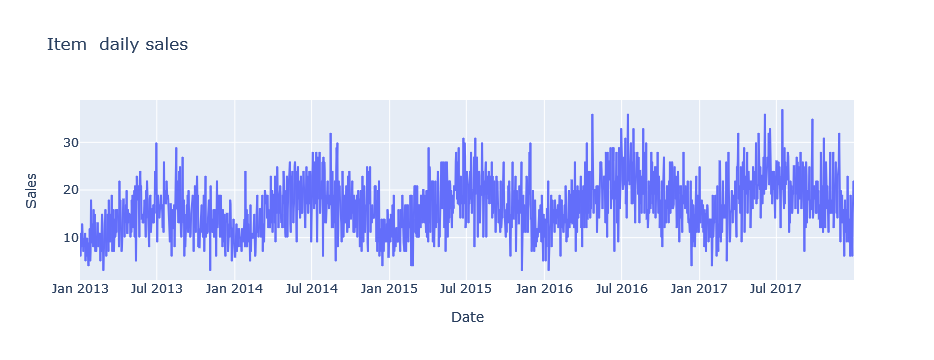

In [14]:

item_daily_sales = df.groupby(['item', 'date'], as_index=False)['sales'].sum()
item_daily_sales_sc = []
for item in item_daily_sales['item'].unique():
    current_item_daily_sales = item_daily_sales[(item_daily_sales['item'] == item)]
    item_daily_sales_sc.append(go.Scatter(x=current_item_daily_sales['date'], y=current_item_daily_sales['sales'], name=('Item %s' % item)))

layout = go.Layout(title='Item  daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=item_daily_sales_sc, layout=layout)
iplot(fig)

In [18]:
df5 = pd.read_csv('item5store1.csv' ,sep=";")

In [22]:
df5

date  item5
0   01-01-13     11
1   02-01-13      6
2   03-01-13      8
3   04-01-13      9
4   05-01-13      8
5   06-01-13     13
6   07-01-13     11
7   08-01-13     10
8   09-01-13      7
9   10-01-13      8
10  11-01-13     10
11  12-01-13      8
12  13-01-13     11
13  14-01-13      5
14  15-01-13     10
15  16-01-13      6
16  17-01-13      7
17  18-01-13     10
18  19-01-13      8
19  20-01-13      9
20  21-01-13      4
21  22-01-13      9
22  23-01-13      6
23  24-01-13     12
24  25-01-13      5
25  26-01-13      7
26  27-01-13     18
27  28-01-13      9
28  29-01-13      9
29  30-01-13      9
30  31-01-13     13

In [25]:
# Split the data into training, validation, and test sets for item 1 
n= len(df5)
n_train5 = int(0.8 * n)
n_test5 = int(0.15 * n)
n_val5 = n - (n_train+ n_test)


train_data5 = df5[:n_train5].drop(columns=['date']).values
train_date5 = df5[:n_train5].drop(columns=['item5'])

test_data5  = df5[-n_test5:].drop(columns=['date']).values
test_date5  = df5[-n_test5:].drop(columns=['item5'])

val_data5  = df5[n_train5:n_train5+n_val5].drop(columns=['date']).values
val_date5   = df5[n_train5:n_train5+n_val5].drop(columns=['item5'])

In [26]:
from sklearn.preprocessing import MinMaxScaler
# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
scaler = scaler.fit(train_data5)

train_data_normalized = scaler.transform(train_data5)
test_data_normalized = scaler.transform(test_data5)
val_data_normalized = scaler.transform(val_data5)

In [27]:
import tensorflow as tf
window_size = 3
BATCH_SIZE = 16
windowed_dataset_train, labels_train = create_window_dataset( train_data_normalized [:, 0:-1],train_data_normalized [:, -1], window_size)

windowed_dataset_train, labels_train = create_window_dataset(train_data_normalized , train_data_normalized [:, -1], window_size)
train_set = tf_dataset(windowed_dataset_train, labels_train, BATCH_SIZE, 1000)
unshuffled_train_set = tf_dataset(windowed_dataset_train, labels_train, BATCH_SIZE, 1000, False)

windowed_dataset_test, labels_test = create_window_dataset(test_data_normalized , test_data_normalized [:, -1] , window_size)
test_set = tf_dataset(windowed_dataset_test, labels_test, BATCH_SIZE,1000, False)

windowed_dataset_validation, labels_validation = create_window_dataset(val_data_normalized ,val_data_normalized [:, -1] , window_size)
validation_set = tf_dataset(windowed_dataset_validation, labels_validation, BATCH_SIZE, 1000,False)


In [28]:
import math
TRAIN_STEP = math.ceil(windowed_dataset_train.shape[0] / BATCH_SIZE)
TEST_STEP = math.ceil(windowed_dataset_test.shape[0] / BATCH_SIZE)
VAL_STEP = math.ceil(windowed_dataset_validation.shape[0] / BATCH_SIZE)

In [29]:
TRAIN_STEP

2

In [256]:

input_shape = (window_size,1)
import tensorflow_addons as tfa
from tensorflow_addons.metrics import RSquare
from sklearn.metrics import explained_variance_score
# Initialisation du modèle CNN RNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=3,
                           strides=1,
                           padding="causal",
                           activation="relu",
                           input_shape= input_shape),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="valid"),
   
    
    tf.keras.layers.Conv1D(filters=32, kernel_size=1, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="valid"),
    tf.keras.layers.SimpleRNN(192, return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.SimpleRNN(128),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tfa.optimizers.LazyAdam(0.001,0.9,0.999,1e-07,False),  # Utilize TFA optimizer
              metrics=['mse',RSquare(),'mae',explained_variance_score],
              run_eagerly=True )


model.summary()

   

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 3, 64)             256       
                                                                 
 max_pooling1d_24 (MaxPooli  (None, 2, 64)             0         
 ng1D)                                                           
                                                                 
 conv1d_25 (Conv1D)          (None, 2, 32)             2080      
                                                                 
 max_pooling1d_25 (MaxPooli  (None, 1, 32)             0         
 ng1D)                                                           
                                                                 
 simple_rnn_24 (SimpleRNN)   (None, 1, 192)            43200     
                                                                 
 dropout_36 (Dropout)        (None, 1, 192)          

In [260]:
history = model.fit(train_set,
                    epochs=60,
                    steps_per_epoch=TRAIN_STEP,
                    validation_data=validation_set,
                    validation_steps=VAL_STEP,
                    batch_size=BATCH_SIZE
                   )

Epoch 1/60
2/2 [==============================] - 0s 248ms/step - loss: 0.0293 - mse: 0.0293 - r_square: 0.5038 - mae: 0.1352 - explained_variance_score: 0.3861 - val_loss: 0.3829 - val_mse: 0.3829 - val_r_square: 0.0000e+00 - val_mae: 0.6188 - val_explained_variance_score: 1.0000
Epoch 2/60
2/2 [==============================] - 0s 220ms/step - loss: 0.0273 - mse: 0.0273 - r_square: 0.5388 - mae: 0.1306 - explained_variance_score: 0.6304 - val_loss: 0.3439 - val_mse: 0.3439 - val_r_square: 0.0000e+00 - val_mae: 0.5864 - val_explained_variance_score: 1.0000
Epoch 3/60
2/2 [==============================] - 0s 215ms/step - loss: 0.0297 - mse: 0.0297 - r_square: 0.4979 - mae: 0.1487 - explained_variance_score: 0.5455 - val_loss: 0.3967 - val_mse: 0.3967 - val_r_square: 0.0000e+00 - val_mae: 0.6298 - val_explained_variance_score: 1.0000
Epoch 4/60
2/2 [==============================] - 0s 220ms/step - loss: 0.0286 - mse: 0.0286 - r_square: 0.5157 - mae: 0.1356 - explained_variance_score: 

In [261]:
#Save model weights
model.save_weights('weights/magazine_model_weights.ckpt')

In [262]:
#Load model weights

model.load_weights('weights/magazine_model_weights.ckpt')



In [263]:
forecast_train = model.predict(unshuffled_train_set, steps=TRAIN_STEP)
forecast_test = model.predict(test_set, steps=TEST_STEP)
forecast_validation= model.predict(validation_set, steps=VAL_STEP)


1/1 [==============================] - 0s 16ms/step


In [264]:
def get_metrics_result(metrics, true_labels, predicted_labels):    
    metrics_result = []
    for metric in metrics:
        metric.reset_states()
        metric.update_state(true_labels, predicted_labels)
        metrics_result.append(metric.result().numpy())
    
    return metrics_result

MAE    MSE  R_SQUARE
                                  
Train       0.026  0.001     0.983
Test        0.025  0.001     0.987
Validation  0.521  0.271     0.000

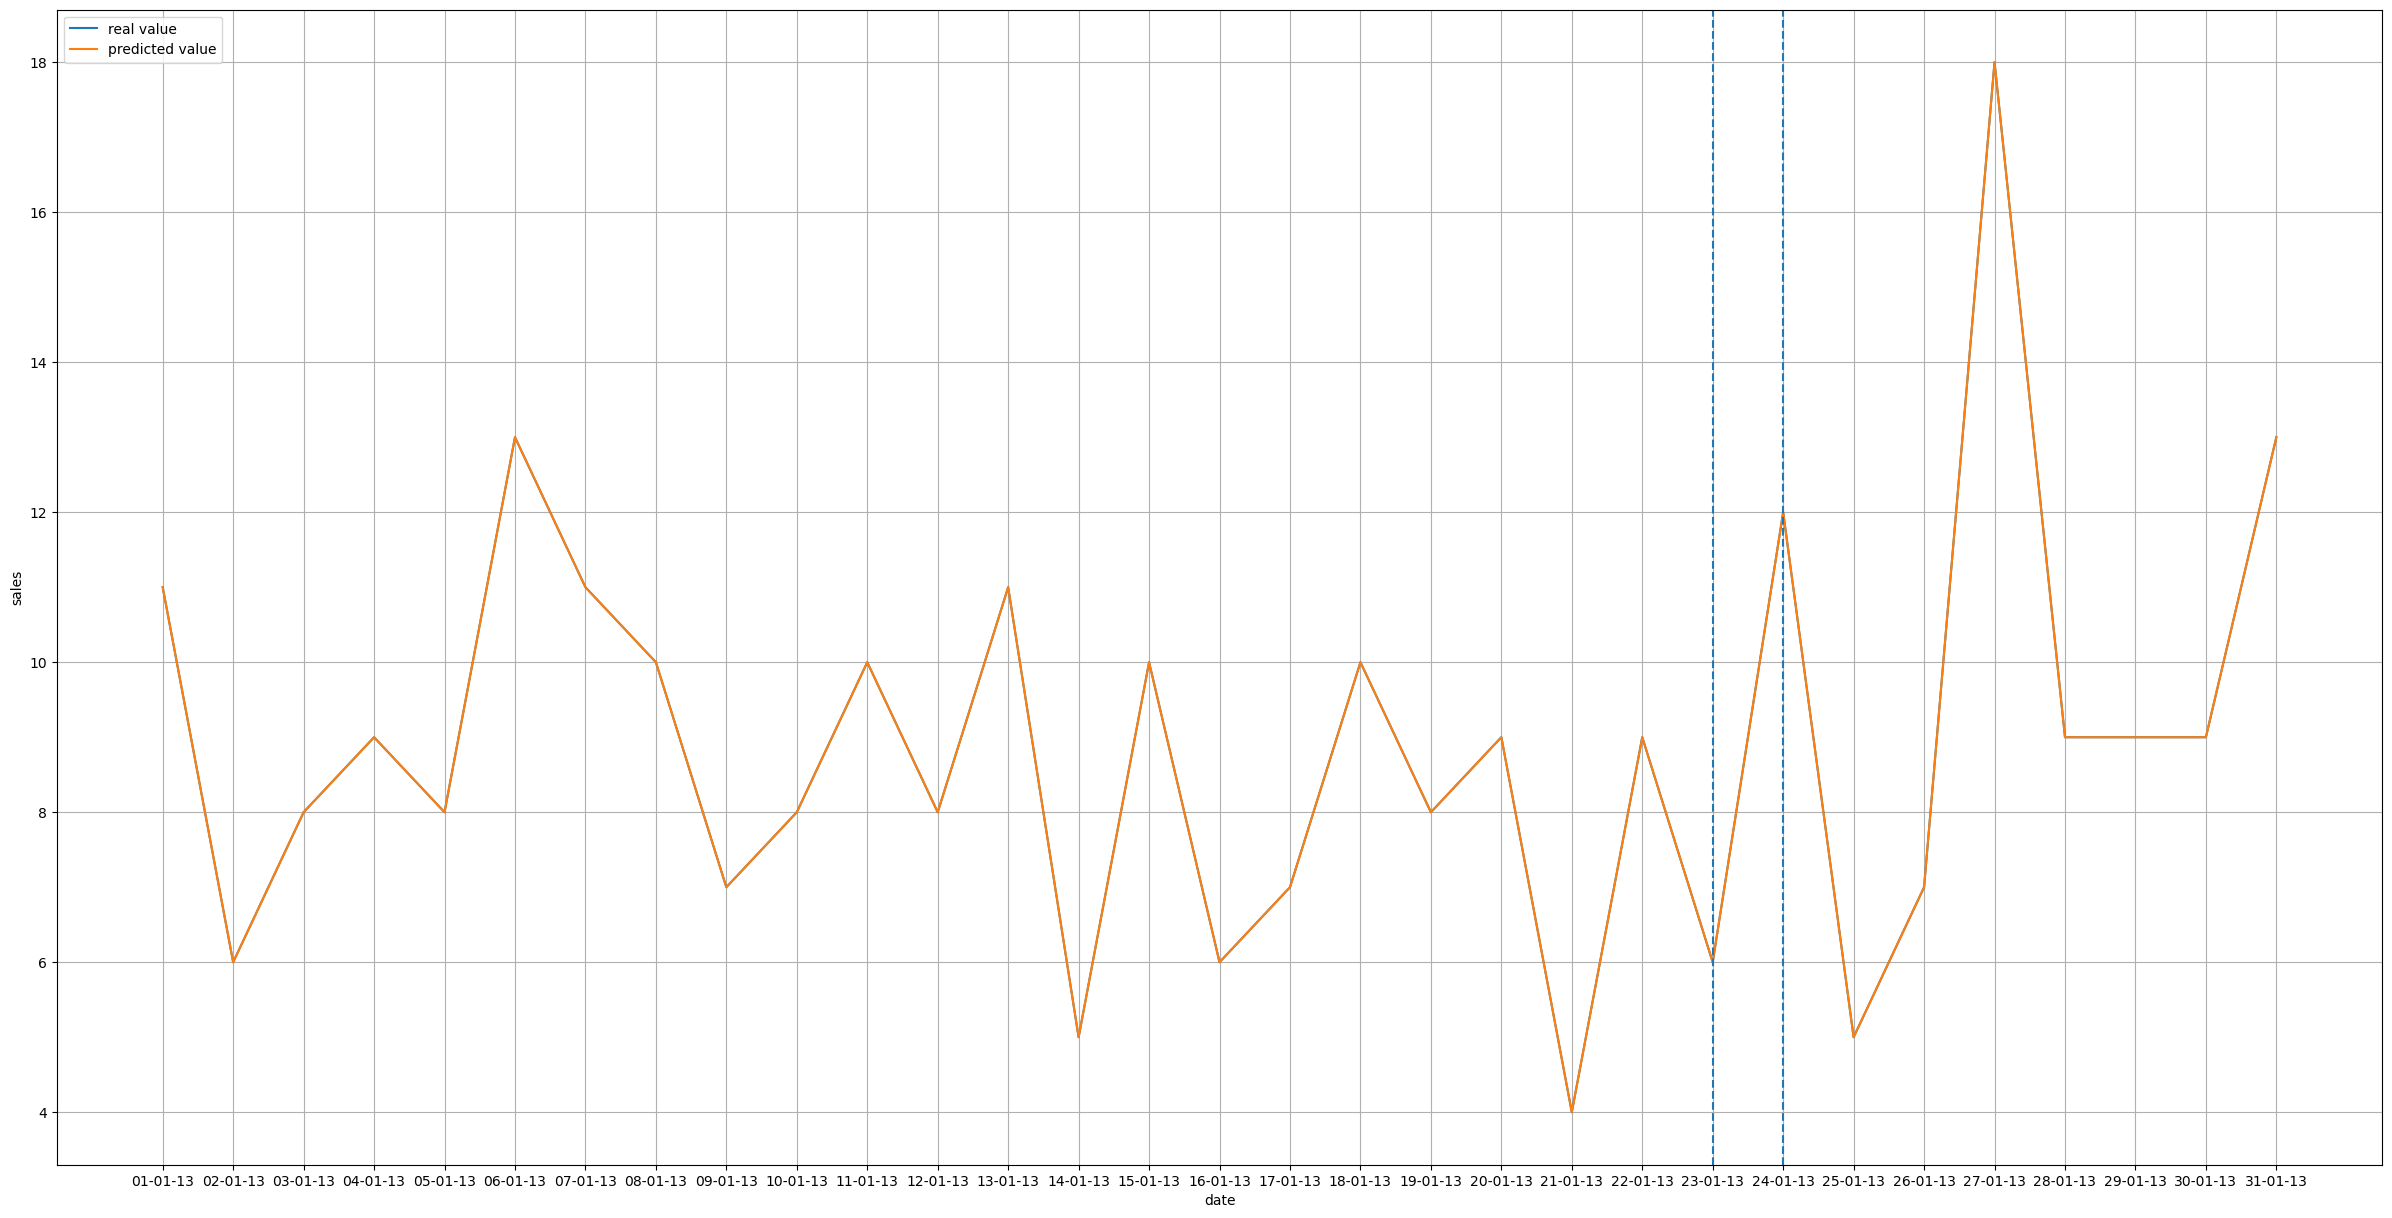

In [265]:
import sklearn
total_forecast = np.concatenate((forecast_train, forecast_test, forecast_validation))
total_labels = np.concatenate((labels_train, labels_test,labels_validation))
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 15))
plot_series(np.arange(total_labels.shape[0]), total_labels, "real value")
plot_series(np.arange(total_labels.shape[0]), total_forecast, "predicted value")
xpositions = [labels_train.shape[0], (labels_train.shape[0] + labels_validation.shape[0])]
for xp in xpositions:
    plt.axvline(x=xp, linestyle='--')
plt.legend(loc='upper left')

metrics = [
    tf.keras.metrics.MeanAbsoluteError(),
    tf.keras.metrics.MeanSquaredError(),
    tfa.metrics.r_square.RSquare(),
    
]
train_metrics = get_metrics_result(metrics, labels_train, forecast_train[:,0])
train_metrics.insert(0, 'Train')

test_metrics = get_metrics_result(metrics, labels_test, forecast_test[:,0])
test_metrics.insert(0, 'Test')

val_metrics = get_metrics_result(metrics,labels_validation, forecast_validation[:,0])
val_metrics.insert(0, 'Validation')

COL_NAMES = ['', 'MAE', 'MSE', 'R_SQUARE']
metrics_table = pd.DataFrame([train_metrics, test_metrics, val_metrics], columns=COL_NAMES)
metrics_table = metrics_table.set_index([''])
metrics_table.round(3)


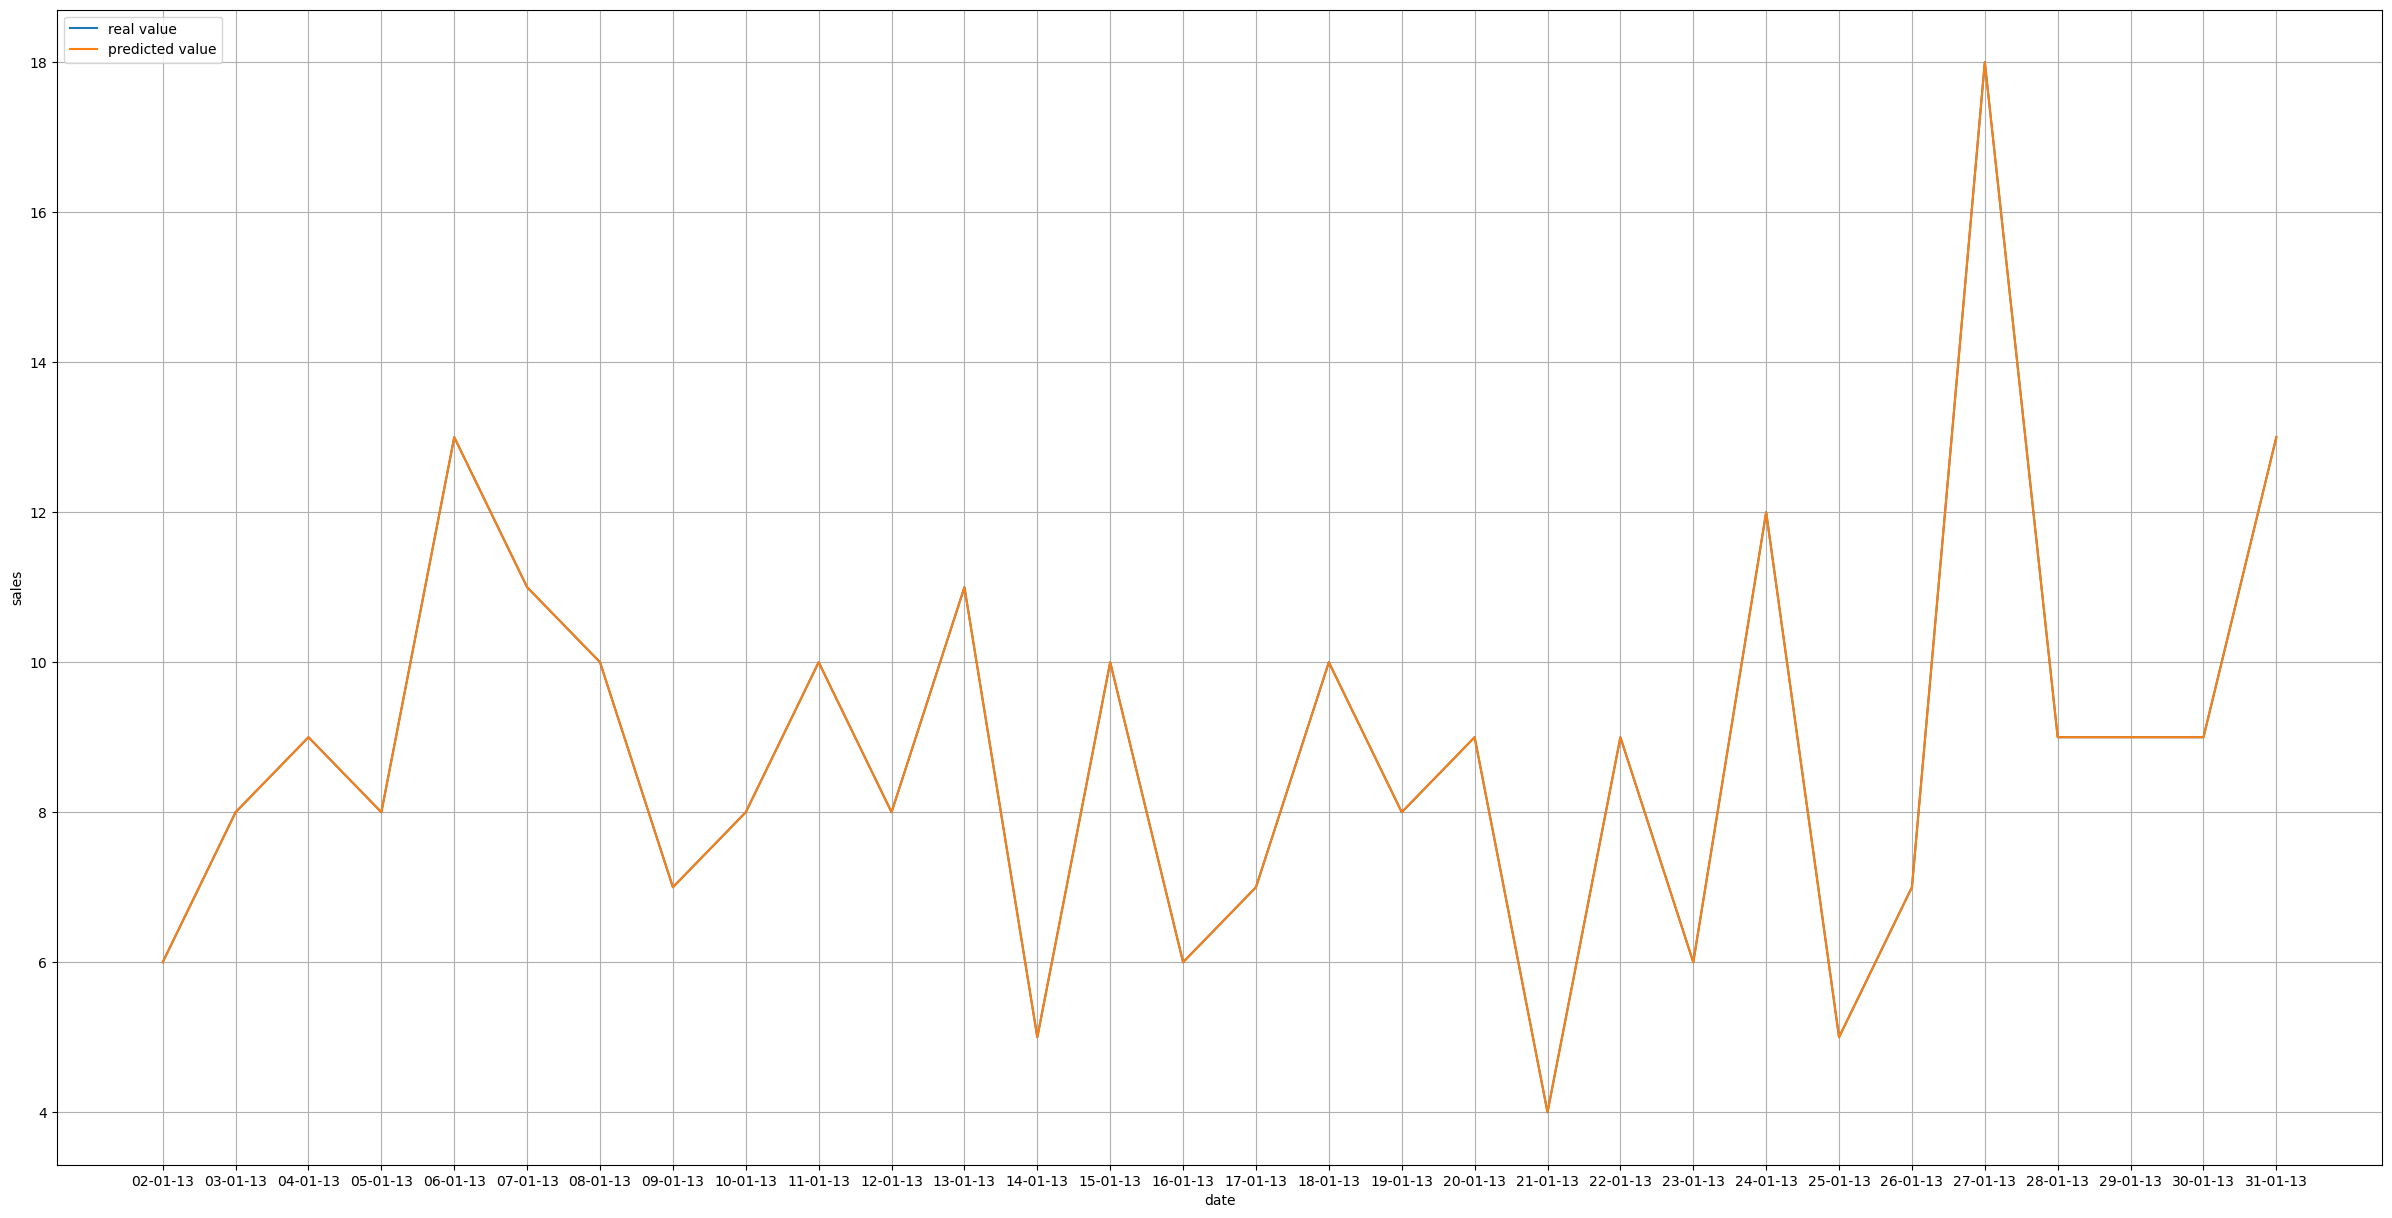

In [250]:
plt.figure(figsize=(30, 15))
plot_series(np.arange(labels_train.shape[0]), labels_train, "real value")
plot_series(np.arange(labels_train.shape[0]), forecast_train[:,0], "predicted value")
plt.legend(loc='upper left')

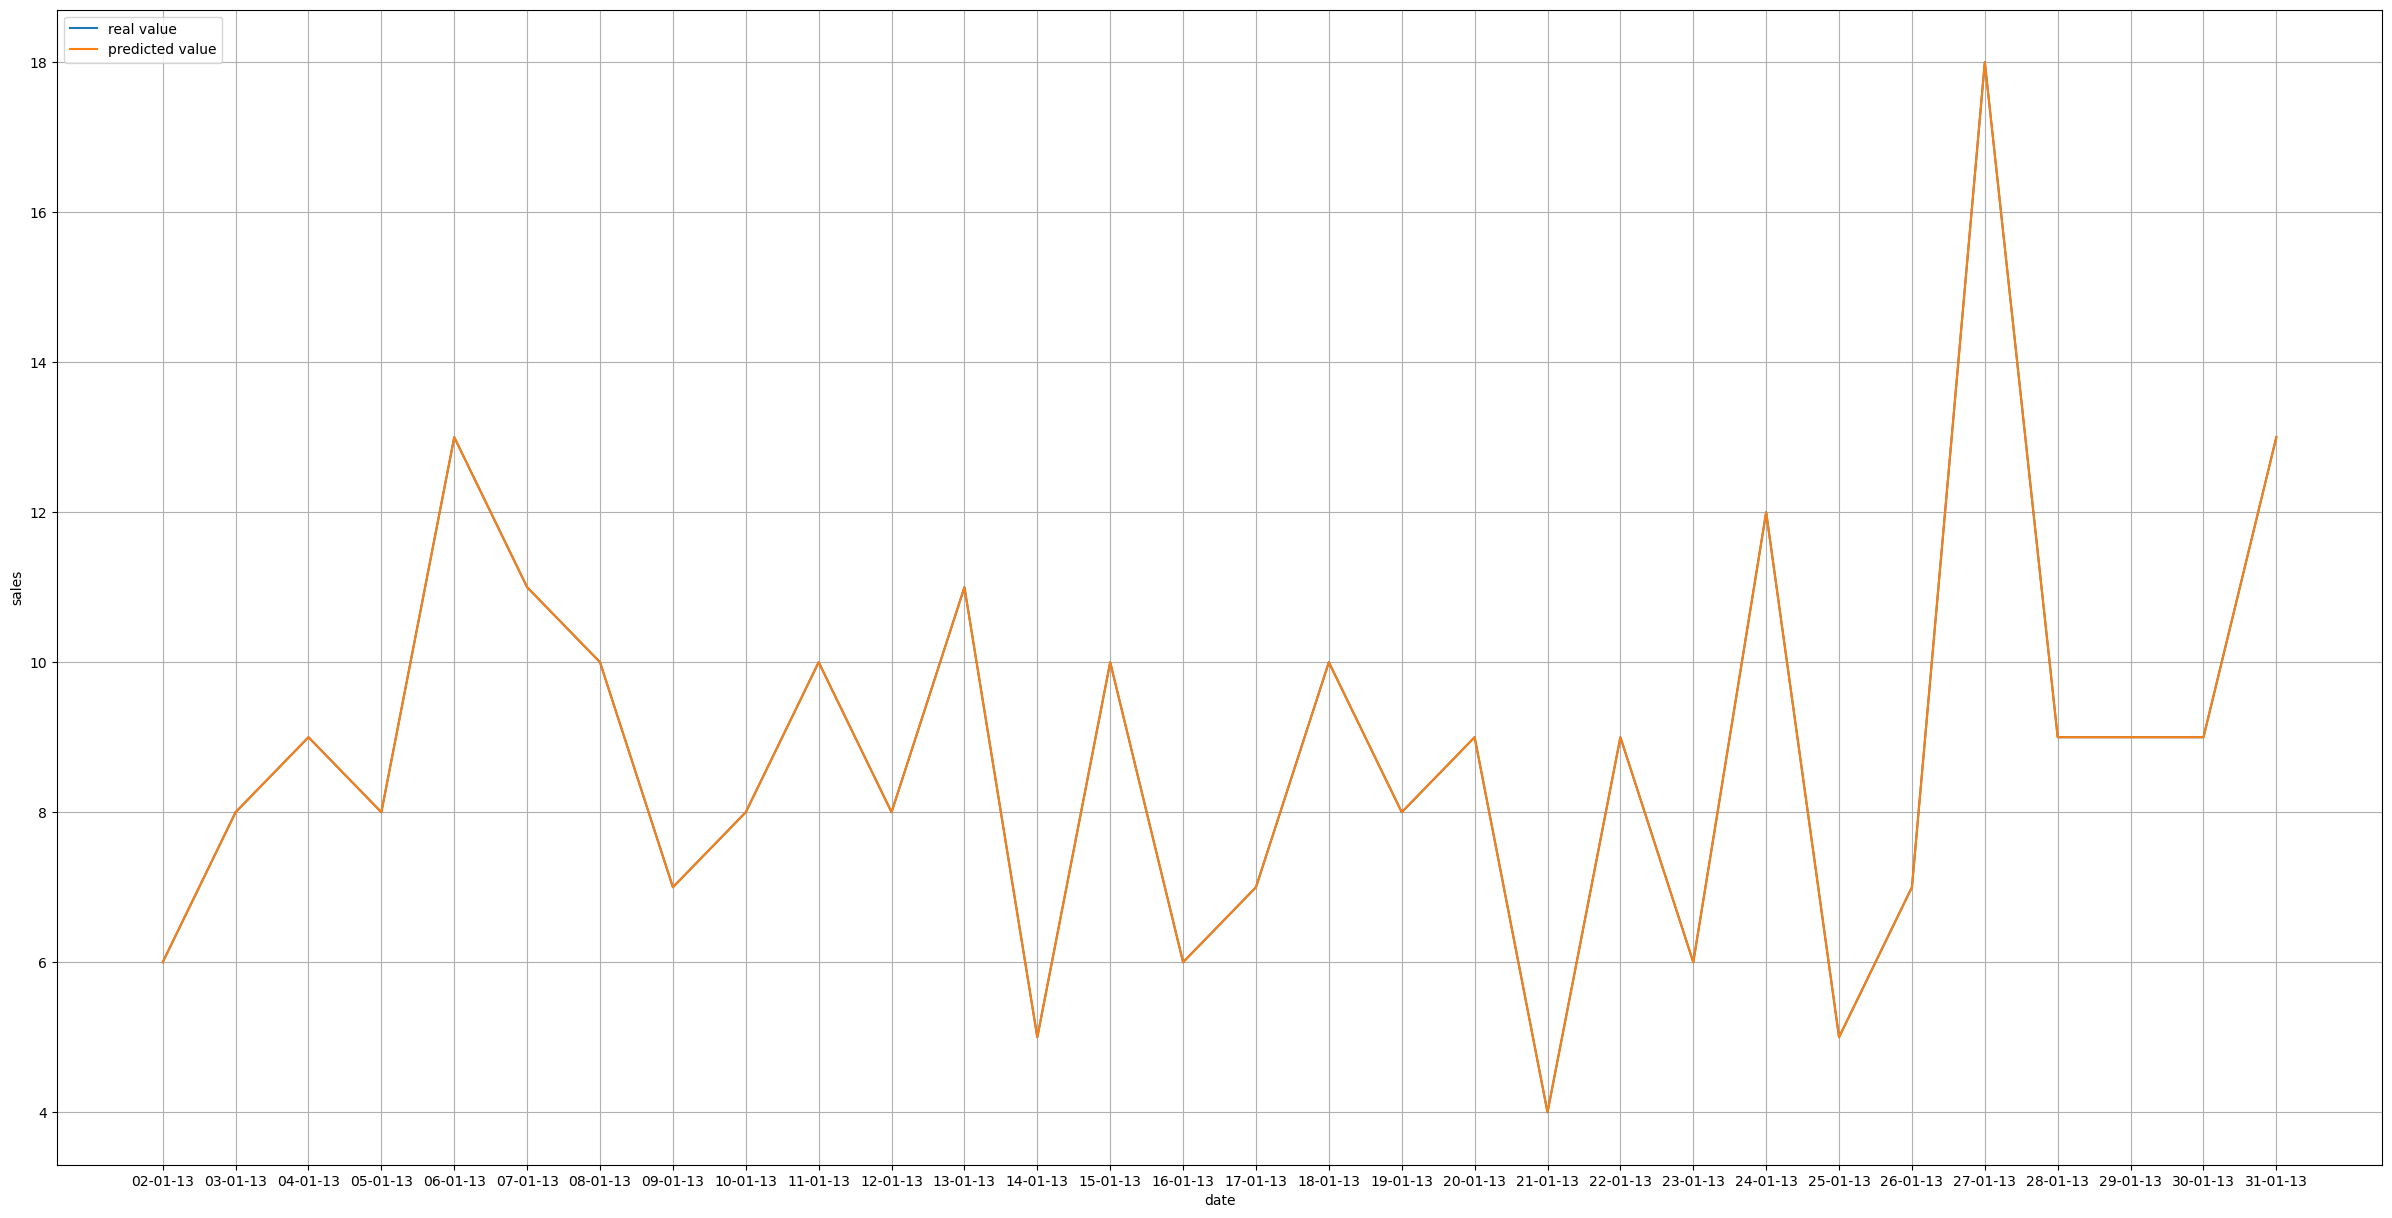

In [235]:
plt.figure(figsize=(30, 15))
plot_series(np.arange(labels_test.shape[0]), labels_test, "real value")
plot_series(np.arange(labels_test.shape[0]), forecast_test[:,0], "predicted value")
plt.legend(loc='upper left')

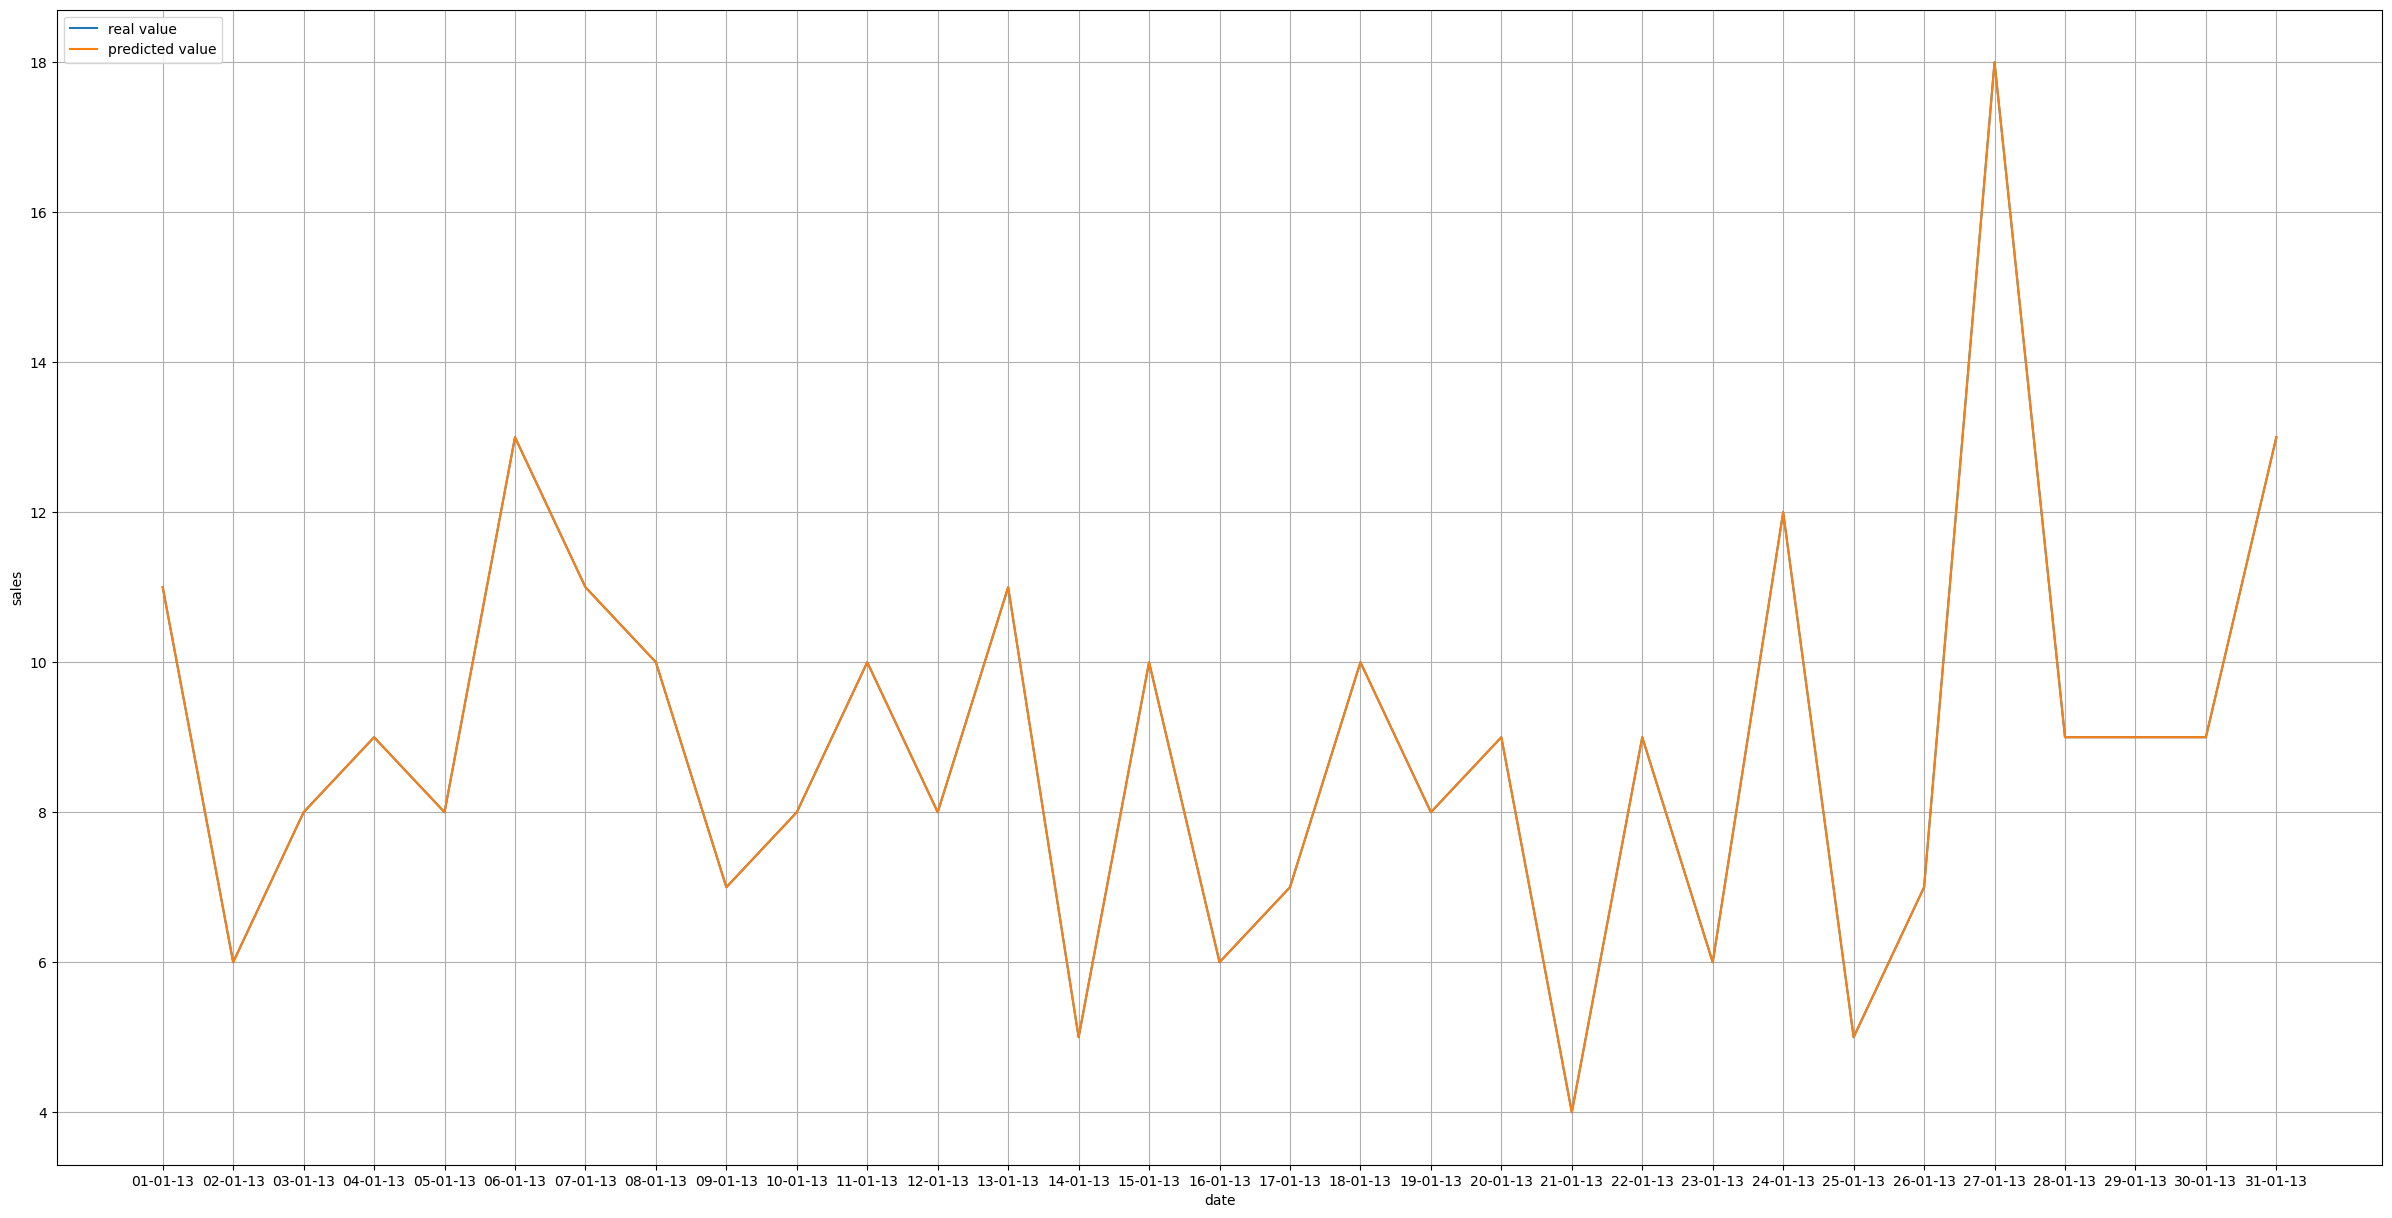

In [226]:
plt.figure(figsize=(30, 15))
plot_series(np.arange(labels_validation.shape[0]), labels_validation, "real value")
plot_series(np.arange(labels_validation.shape[0]), forecast_validation[:,0], "predicted value")
plt.legend(loc='upper left')

In [273]:
df.head()

date  item5
0  01-01-13     11
1  02-01-13      6
2  03-01-13      8
3  04-01-13      9
4  05-01-13      8

In [278]:
df.resample('d', on='date').mean().iplot()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'